In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import entropy

plt.rcParams["figure.subplot.left"] = 0.18
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.2

In [2]:
h = np.linspace(0.0, 1.0, num=501)[1::] # exclude the first because it can diverge
h = h - (h[1]-h[0])/2
kappa = np.arange(1,500)

166.50006796370826

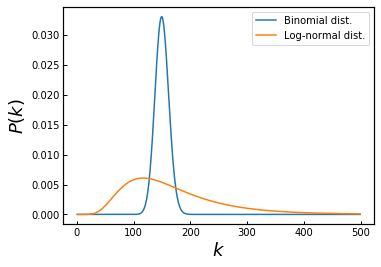

In [3]:
def _p_kappa(kappa):
    # delta function
    #return np.where(kappa == 150, 1, 0)
    # binomial distribution
    _n = 5000
    _p = 0.03
    b = binom(_n, _p)
    pmf = b.pmf(kappa)
    return pmf / np.sum(pmf)   # normalize to reduce error

def _power_law_p_kappa(kappa, alpha=-3):
    p_kappa_ = kappa.astype(np.float64) ** alpha
    return p_kappa_ / np.sum(p_kappa_)

def _log_normal_p_kappa(kappa, mu, sigma):
    pdf = (np.exp(-(np.log(kappa) - np.log(mu))**2 / (2 * sigma**2)) / (kappa * sigma * np.sqrt(2 * np.pi)))
    return pdf / np.sum(pdf)

P_kappa = _p_kappa(kappa)
plt.plot(kappa,P_kappa, label="Binomial dist.")
#P_kappa = _power_law_p_kappa(kappa, -2)
P_kappa = _log_normal_p_kappa(kappa, 150, 0.5)
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.plot(kappa,P_kappa, label="Log-normal dist.")
plt.legend()
plt.savefig("binom_lognormal_pkappa.pdf")
kappa_mean = np.sum(kappa*P_kappa)
kappa_mean

In [4]:
def gen_mean(x,y,beta):  # when beta<=-10 or >=10, minimum or maximum is used
    if beta == 0:
        return np.sqrt(x*y)
    elif beta <= -10:
        return np.minimum(x,y)
    elif beta >= 10:
        return np.maximum(x,y)
    else:
        return ((x**beta+y**beta)/2)**(1.0/beta)

r = lambda x, y: gen_mean(x,y,-10)

r(1.0,3.0)

1.0

0 0.10000000000000012 0.04778387985591173
1 0.12299808886867653 0.05823882438170091
2 0.13515856843619578 0.06358529297946668
3 0.1431126624982933 0.06700318318110672
4 0.1488895307767747 0.0694437516001855
5 0.1533575603188384 0.07130646601127827
6 0.15696196536958396 0.07279298465380003
7 0.1599588905958763 0.07401783850248328
8 0.16250806930263234 0.07505166858547367
9 0.2150053275905362 0.09466395140749806
10 0.2249572093671148 0.09802413409739688
11 0.22859961778438756 0.09922645946325159


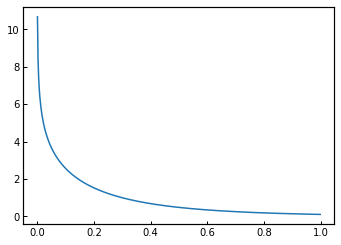

In [5]:
def _rho(h, alpha=0.8, x_0=0.3):
    # Weibull distribution
    ro = alpha/x_0*(h/x_0)**(alpha-1) * np.exp( -(h/x_0)**alpha )
    dh = h[1]-h[0]
    return ro / (np.sum(ro)*dh)   # normalize to reduce numerical error


def _rho_average_control(h, r, alpha=1.0, r_bar=0.2):
    h_prime = np.copy(h).reshape([1,h.shape[0]])
    h_ = h.reshape( [h.shape[0],1] )
    rhh = r(h_, h_prime)
    dh = h[1]-h[0]
    
    def calculate_r_bar(x_0):
        rho_ = _rho(h, alpha, x_0)
        r_bar_h = np.sum( rhh * rho_.reshape([1,h.shape[0]]) * dh, axis=1)
        return np.sum(r_bar_h * rho_ * dh, axis=0)
    
    def estimate_x_0(results,y_target):
        xs = np.array( [x[0] for x in results] )
        ys = np.array( [x[1] for x in results] )
        A = np.vstack([xs, np.ones(len(xs))]).T
        m, c = np.linalg.lstsq(A, ys, rcond=None)[0]
        return (y_target - c) / m
    
    results = [ (1.0, 1.0), (0.0, 0.0) ]  # heuristic
    for i in range(100):
        x_0 = estimate_x_0(results, r_bar)
        r_bar_c = calculate_r_bar(x_0)
        print(i,x_0,r_bar_c)
        results.append( (x_0,r_bar_c) )
        if len(results) > 10:
            results.pop(0)
        if abs(r_bar_c - r_bar) < 0.001:
            return (x_0, _rho(h, alpha, x_0))

#rho = _rho(h)
x_0, rho = _rho_average_control(h, r, alpha=0.8, r_bar=0.1)
plt.plot(h, rho)

0.09922645946325159


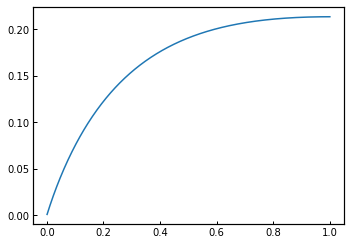

In [6]:
class NodalSampling:
    
    def __init__(self, h, kappa, rho_h, P_kappa, r):
        self.h = h
        self.nh = h.shape[0]
        self.dh = self.h[1]-self.h[0]
        self.kappa = kappa
        self.nkappa = kappa.shape[0]
        self.rho_h = rho_h
        assert( rho_h.shape == h.shape )
        self.P_kappa = P_kappa
        assert( P_kappa.shape == kappa.shape )
        self.r = r
        self.k = np.arange(0, np.amax(self.kappa)+1)
        self.nk = self.k.shape[0]
        self.results = {
            "r_bar_h": None,
            "r_bar": None,
            "g": None,
            "P_k": None,
            "r_nn_h": None,
            "p_hprime_given_h": None,
            "c_h": None,
            "g_star": None
        }
        
    def r_bar_h(self):
        # sum_{h'} rho(h') r(h,h')
        if self.results["r_bar_h"] is not None:
            return self.results["r_bar_h"]
        h_prime = np.copy(self.h).reshape([1,self.nh])
        h_ = self.h.reshape( [self.nh,1] )
        rhh = self.r(h_, h_prime)
        dr = rhh*rho.reshape([1,self.nh])*self.dh
        self.results["r_bar_h"] = np.sum(dr,axis=1)
        return self.results["r_bar_h"]
    
    def r_bar(self):
        # sum_{h,h'} rho(h') rho(h) r(h,h')
        if self.results["r_bar"] is not None:
            return self.results["r_bar"]
        y = self.r_bar_h() * self.rho_h * self.dh
        self.results["r_bar"] = np.sum(y)
        return self.results["r_bar"]
    
    def g(self):
        # g(k|h,kappa) = \binom(kappa, k) r(h)^k ( 1-r(h))^{kappa-k}
        #   k,h,kappa are 0th,1st,2nd axis, respectively
        if self.results["g"] is not None:
            return self.results["g"]
        _p = self.r_bar_h().reshape([1,self.nh,1])
        _kappa = self.kappa.reshape([1,1,self.nkappa])
        b = binom(_kappa, _p)
        _k = self.k.reshape([self.nk,1,1])
        self.results["g"] = b.pmf(_k)
        return self.results["g"]
    
    def P_k(self):
        if self.results["P_k"] is not None:
            return self.results["P_k"]
        _g = g * self.rho_h.reshape([1,self.nh,1]) * self.P_kappa.reshape([1,1,self.nkappa])
        self.results["P_k"]
        self.results["P_k"] = np.sum(_g, axis=(1,2)) * self.dh
        return self.results["P_k"]
    
    def r_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        if self.results["r_nn_h"] is not None:
            return self.results["r_nn_h"]
        h_prime = np.copy(self.h).reshape([1,self.nh])
        rho_h_prime = self.rho_h.reshape([1,self.nh])
        r_bar_h_prime = self.r_bar_h().reshape([1,self.nh])
        r_bar_h = self.r_bar_h().reshape( [self.nh,1] )
        h = self.h.reshape( [self.nh,1] )
        x = r( h, h_prime ) * rho_h_prime * r_bar_h_prime / r_bar_h
        self.results["r_nn_h"] = np.sum( x, axis=1 ) * self.dh
        return self.results["r_nn_h"]
    
    def k_nn_k(self, kappa_nn):
        # k, h, kappa are axis=0,1,2, respectively
        assert( kappa_nn.shape == self.kappa.shape )
        r_nn_h_ = self.r_nn_h().reshape( [1,self.nh,1] )
        kappa_nn_ = kappa_nn.reshape( [1,1,self.nkappa] )
        return 1 + np.sum( self.g_star() * r_nn_h_ * (kappa_nn_-1), axis=(1,2) ) * self.dh;
    
    def _p_hprime_given_h(self):
        # h,h' are axis-0,1
        # p(h'|h) = r(h',h) rho(h') / r_bar(h)
        if self.results["p_hprime_given_h"] is not None:
            return self.results["p_hprime_given_h"]
        h_ = self.h.reshape( (self.nh,1) )
        h_prime = self.h.reshape( (1,self.nh) )
        rho_hprime = self.rho_h.reshape( (1,self.nh) )
        rbar_h = self.r_bar_h().reshape( (self.nh,1) )
        self.results["p_hprime_given_h"] = r(h_, h_prime) * rho_hprime / rbar_h
        return self.results["p_hprime_given_h"]
    
    def c_h(self):
        # h, h', h'' are axis-0,1,2, respectively
        # \sum_{h', h''} = r(h', h'') * p(h'|h) * p(h''|h)
        if self.results["c_h"] is not None:
            return self.results["c_h"]
        nh = self.nh
        h_ = self.h.reshape( (nh,1,1) )
        h_prime = self.h.reshape( (1,nh,1) )
        h_prime2 = self.h.reshape( (1,1,nh) )
        p_hprime_given_h_ = self._p_hprime_given_h().reshape( (nh,nh,1) )
        p_hprime2_given_h_ = self._p_hprime_given_h().reshape( (nh,1,nh) )
        r_ = self.r(h_prime, h_prime2).reshape( (1,nh,nh) )
        self.results["c_h"] = np.sum( r_ * p_hprime_given_h_ * p_hprime2_given_h_, axis=(1,2) ) * self.dh * self.dh
        return self.results["c_h"]
    
    def c_k(self, c_o_kappa):
        # k, h, kappa are axis-0,1,2, respectively
        # 1/P(k) * \sum_{h,\kappa} g(k|h,\kappa) rho(h) P(\kappa) c_h c_o(\kappa)
        _rho_h = self.rho_h.reshape( (1,self.nh,1) )
        _p_kappa = self.P_kappa.reshape( (1,1,self.nkappa) )
        _c_h = self.c_h().reshape( (1,self.nh,1) )
        Pk = self.P_k()
        _Pk = Pk[Pk>0]
        _g = self.g()[Pk>0,:,:]
        return 1.0 / _Pk * np.sum( _g * _rho_h * _p_kappa * _c_h * c_o_kappa, axis=(1,2) ) * self.dh

    def g_star(self):
        # g*(h,kappa|k) = g(k|h,kappa)rho(h)P_o(kappa) / P(k)
        if self.results["g_star"] is not None:
            return self.results["g_star"]
        Pk = self.P_k()
        Pk_ = Pk[ Pk > 0 ]
        Pk_ = Pk_.reshape( [Pk_.shape[0],1,1,] )
        _g = g[Pk > 0,:,:]
        rho_h_ = self.rho_h.reshape( [1,self.nh,1] )
        p_kappa_ = self.P_kappa.reshape( [1,1,self.nkappa] )
        self.results["g_star"] = _g / Pk_ * rho_h_ * p_kappa_
        return self.results["g_star"]

        
sampling = NodalSampling(h=h, kappa=kappa, rho_h=rho, P_kappa=P_kappa, r=r)
plt.plot(h, sampling.r_bar_h())
print(sampling.r_bar())

(500, 500, 499)


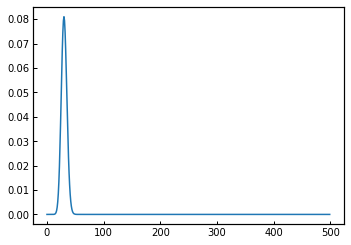

In [7]:
g = sampling.g()
print(g.shape)
plt.plot(sampling.k, g[:,300,150])

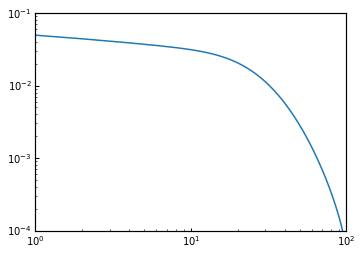

In [8]:
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e0,1e2)
plt.ylim(1.0e-4,1.0e-1)
plt.plot( sampling.k, sampling.P_k() )

In [9]:
# kappa_mean
(sampling.r_bar() * np.sum(kappa*P_kappa), np.sum(sampling.P_k()*sampling.k) )


(16.521212244429535, 16.521212244429687)

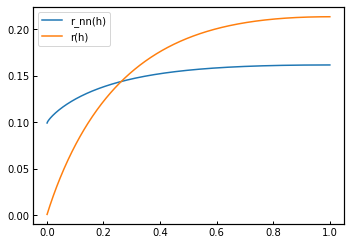

In [10]:
plt.plot(h, sampling.r_nn_h(), label="r_nn(h)")
plt.plot(h, sampling.r_bar_h(), label="r(h)")
plt.legend()

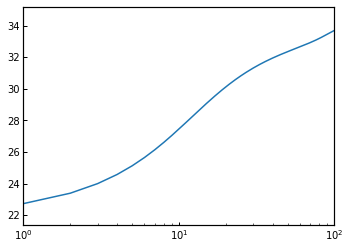

In [11]:
kappa_mean = np.sum(kappa * P_kappa)
kappa2_mean = np.sum(kappa**2 * P_kappa)
kappa_nn = np.full(kappa.shape, kappa2_mean/kappa_mean)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling.k[sampling.P_k()>0], k_nn)

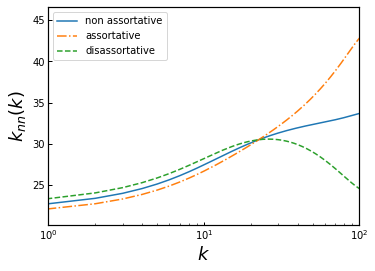

In [12]:
kappa_mean = np.sum(kappa * P_kappa)
kappa2_mean = np.sum(kappa**2 * P_kappa)
kappa_nn_mean = kappa2_mean / kappa_mean
k = sampling.k[ sampling.P_k()>0]

kappa_nn = np.full(kappa.shape, kappa_nn_mean)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")
plt.xlim(1.0e0, 1.0e2)
plt.plot(k, k_nn, '-', label="non assortative")

kappa_nn = kappa_nn_mean + (kappa-kappa_mean)*0.2
#plt.plot(kappa, kappa_nn)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(k, k_nn, '-.', label="assortative")

kappa_nn = kappa_nn_mean + (kappa-kappa_mean)*(-0.2)
#plt.plot(kappa, kappa_nn)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(k, k_nn, '--', label="disassortative")
plt.legend(loc="upper left")
plt.savefig("knn_lognormal_experiment.pdf")

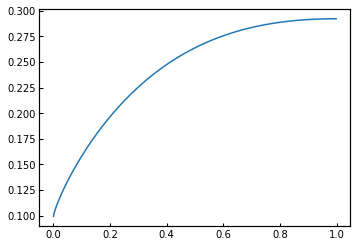

In [13]:
plt.plot(sampling.h, sampling.c_h())

/Users/murase/.local/share/virtualenvs/sim_sampling_analysis-uCS-L3cL/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in true_divide


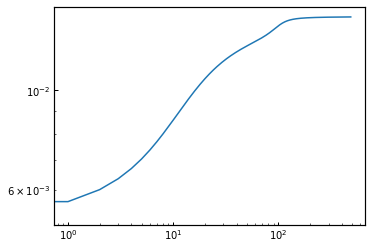

In [14]:
c_o_kappa = 0.05
plt.yscale("log")
plt.xscale("log")
plt.plot(sampling.k[sampling.P_k()>0], sampling.c_k(c_o_kappa))

/Users/murase/.local/share/virtualenvs/sim_sampling_analysis-uCS-L3cL/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in true_divide
/Users/murase/.local/share/virtualenvs/sim_sampling_analysis-uCS-L3cL/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in multiply


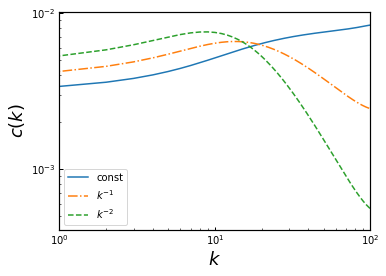

In [15]:
k = sampling.k[ sampling.P_k() > 0 ]
c_o = 0.03 # fix the original clustering coefficient
c_o_kappa = np.full(kappa.shape, c_o)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.xlabel(r"$k$")
plt.ylabel(r"$c(k)$")
plt.plot(k, sampling.c_k(c_o_kappa), '-', label="const")

c_o_kappa = 1.0 / kappa
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(k, sampling.c_k(c_o_kappa), '-.', label=r"$k^{-1}$")
plt.legend(loc="best")

c_o_kappa = 1.0 / (kappa**2)
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(k, sampling.c_k(c_o_kappa), '--', label=r"$k^{-2}$")
plt.legend(loc="best")
plt.savefig("ck_lognormal_experiment.pdf")

ValueError: x and y must have same first dimension, but have shapes (500,) and (493,)

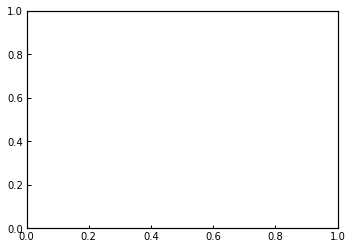

In [16]:
g_star_k_h = np.sum(sampling.g_star(), axis=2)
#plt.plot(h, g_star_k_h[10,:])
#plt.plot(h, rho)
kls = [entropy( g_star_k_h[k,:], rho ) for k in range( g_star_k_h.shape[0] )]
plt.plot(sampling.k, kls)

In [ ]:
g_star_k_kappa = np.sum(sampling.g_star(), axis=1) * (h[1]-h[0])
plt.plot(kappa, g_star_k_kappa[10,:], label=r"$k = 10$")
plt.plot(kappa, g_star_k_kappa[50,:], label=r"$k = 50$")
plt.plot(kappa, P_kappa, label =r"$P(\kappa)$")
plt.legend()

In [ ]:
#kls = [entropy( P_kappa, g_star_k_kappa[k,:] ) for k in range( g_star_k_h.shape[0] )]
kls = [entropy( g_star_k_kappa[k,:], P_kappa ) for k in range( g_star_k_h.shape[0] )]
plt.xscale("log")
plt.yscale("linear")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(0,4)
plt.plot(k, kls)
plt.savefig("kl_divergence.pdf")